In [24]:
# =====================================================
# Import Library
# =====================================================
import os
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Reshape, Lambda
from tensorflow.keras import backend as K

In [25]:
# =====================================================
# Load dataset dari folder
# =====================================================
def load_dataset(dataset_path):
    images_gray = []
    labels = []
    classes = os.listdir(dataset_path)
    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        if not os.path.isdir(cls_path):
            continue
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Preprocessing: manual thresholding + noise removal
                _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
                clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
                images_gray.append(clean)
                labels.append(cls)
    return images_gray, labels

In [26]:
# =====================================================
# Fitur fisik dan GLCM
# =====================================================
def categorize_length_mm(length_mm):
    if 6.5 <= length_mm < 7.0:
        return "pendek"
    elif 7.0 <= length_mm <= 8.5:
        return "panjang"
    else:
        return "lainnya"

def categorize_area_cm2(area_cm2):
    if area_cm2 < 1.0:
        return "kecil"
    elif area_cm2 < 3.0:
        return "sedang"
    else:
        return "besar"

def extract_physical_features(img, pixels_per_cm, pixels_per_mm):
    features = []

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)

        area_cm2 = cv2.contourArea(cnt) / (pixels_per_cm**2)
        perimeter_mm = cv2.arcLength(cnt, True) / pixels_per_mm
        length_mm = h / pixels_per_mm
        width_mm = w / pixels_per_mm
    else:
        area_cm2 = perimeter_mm = length_mm = width_mm = 0

    # Size/Shape
    features.extend([area_cm2, perimeter_mm, length_mm, width_mm])

    # Area category one-hot
    area_mapping = {"kecil": [1,0,0], "sedang": [0,1,0], "besar": [0,0,1]}
    features.extend(area_mapping[categorize_area_cm2(area_cm2)])

    # Length category one-hot
    length_mapping = {"pendek": [1,0], "panjang": [0,1], "lainnya": [0,0]}
    features.extend(length_mapping[categorize_length_mm(length_mm)])

    # GLCM
    glcm = graycomatrix(img, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    features.extend([
        graycoprops(glcm, 'contrast')[0,0],
        graycoprops(glcm, 'dissimilarity')[0,0],
        graycoprops(glcm, 'homogeneity')[0,0],
        graycoprops(glcm, 'energy')[0,0],
        graycoprops(glcm, 'correlation')[0,0]
    ])
    return features

In [27]:
# =====================================================
# Preprocessing gambar & CapsuleNet utility
# =====================================================
def preprocess_image(img, target_size=(224,224)):
    img_resized = cv2.resize(img, target_size)
    img_resized = img_resized / 255.0
    return img_resized

def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

def create_capsule_layer(inputs, num_capsules=10, dim_capsule=16):
    u = Conv2D(filters=num_capsules*dim_capsule, kernel_size=3, strides=2, padding='valid', activation='relu')(inputs)
    u = Reshape(target_shape=[-1, dim_capsule])(u)
    u = Lambda(squash)(u)
    return u

In [28]:
# =====================================================
# Ekstraksi fitur MobileNet+CapsuleNet
# =====================================================
def extract_deep_features(images):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    capsule_features = create_capsule_layer(x)
    features_model = Model(inputs=base_model.input, outputs=capsule_features)
    
    # Predict dan flatten
    deep_features = features_model.predict(images, verbose=0)
    deep_features = deep_features.reshape(deep_features.shape[0], -1)
    return deep_features

In [29]:
# =====================================================
# Gabungkan semua fitur
# =====================================================
def prepare_dataset(images_gray, labels, pixels_per_cm, pixels_per_mm):
    # Preprocess untuk MobileNet
    images_rgb = np.array([preprocess_image(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)) for img in images_gray])
    # Deep features
    deep_feats = extract_deep_features(images_rgb)
    # Physical & GLCM features
    phys_feats = np.array([extract_physical_features(img, pixels_per_cm, pixels_per_mm) for img in images_gray])
    # Gabungkan
    X = np.hstack([deep_feats, phys_feats])
    y = np.array(labels)
    return X, y

In [30]:
# =====================================================
# Training & Evaluasi Random Forest
# =====================================================
def train_random_forest(X_train, y_train, n_estimators=100):
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    return rf

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Convert classification report to DataFrame
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # Ambil hanya kelas (tanpa avg/accuracy)
    df_classes = df_report.iloc[:-3][['precision', 'recall', 'f1-score']]

    # Barplot
    df_classes.plot(kind='bar', figsize=(10,6))
    plt.title("Precision, Recall, F1-Score per Class")
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

Preparing features...
Training Random Forest...
Evaluating model...
Accuracy: 0.8630705394190872
Confusion Matrix:
 [[81  0  0]
 [ 4 59 17]
 [ 1 11 68]]
Classification Report:
               precision    recall  f1-score   support

      INPARI       0.94      1.00      0.97        81
        IR16       0.84      0.74      0.79        80
   ROJO LELE       0.80      0.85      0.82        80

    accuracy                           0.86       241
   macro avg       0.86      0.86      0.86       241
weighted avg       0.86      0.86      0.86       241

Accuracy: 0.8630705394190872


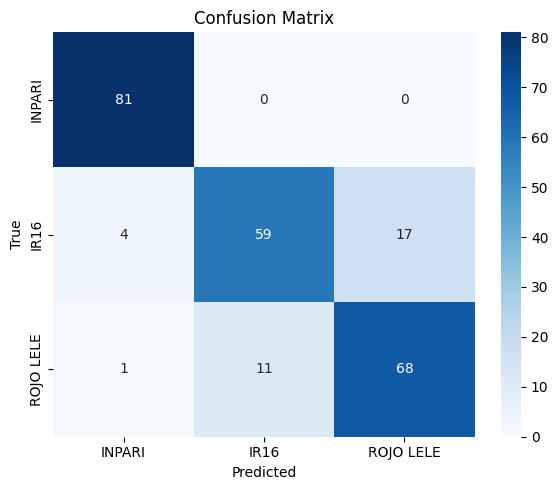

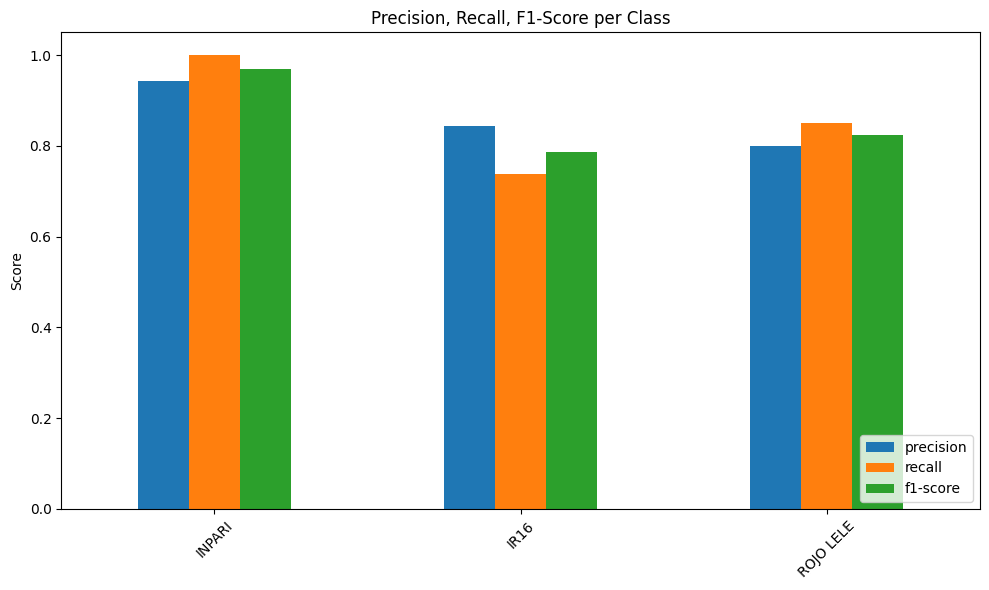

In [31]:
# =====================================================
# Main Program
# =====================================================
if __name__ == "__main__":
    dataset_path = "C:/Users/raga/RAGA/Projects/Program GLCM/GABAH"
    pixels_per_cm = 50
    pixels_per_mm = pixels_per_cm / 10

    # Load dataset grayscale dengan threshold manual (tanpa Otsu)
    images_gray = []
    labels = []
    for cls in os.listdir(dataset_path):
        cls_path = os.path.join(dataset_path, cls)
        if not os.path.isdir(cls_path):
            continue
        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
                clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((3,3),np.uint8))
                images_gray.append(clean)
                labels.append(cls)

    print("Preparing features...")
    X, y = prepare_dataset(images_gray, labels, pixels_per_cm, pixels_per_mm)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Training Random Forest...")
    rf_model = train_random_forest(X_train, y_train)

    print("Evaluating model...")
    evaluate_model(rf_model, X_test, y_test)